In [27]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from scipy.stats import mode

import kaggle_functions as kaggle
import importlib
importlib.reload(kaggle);

model_number = 'stacking'
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

In [91]:
# Create datasets
train_dataset, valid_dataset, valid_labels = kaggle.load_train_as_dataset()
x_test_real = kaggle.load_test_set()

In [92]:
filepaths_to_load = {
    'model6/VGG_6_79': 0.79,
    'model7/DeeperVGG_4_79': 0.79,
    'model7/DeeperVGG_6_84': 0.84,
    'model8/VGGRes_3_79': 0.79
}

valid_predictions = np.zeros((2378, 11, len(filepaths_to_load)))
test_predictions = np.zeros((17831, 11, len(filepaths_to_load)))

for index, filepath in enumerate(filepaths_to_load):
    print(f'Loading and predicting {filepath}')
    model = keras.models.load_model(f'models/{filepath}')
    softmax_valid_pred = np.array(tf.nn.softmax(model.predict(valid_dataset.batch(128))))
    softmax_test_pred = np.array(tf.nn.softmax(model.predict(x_test_real)))
    
    valid_predictions[:, :, index] = softmax_valid_pred
    test_predictions[:, :, index] = softmax_test_pred

Loading and predicting model6/VGG_6_79
Loading and predicting model7/DeeperVGG_4_79
Loading and predicting model7/DeeperVGG_6_84
Loading and predicting model8/VGGRes_3_79


In [ ]:
# Determine best weighting factors (possibly overfitting since we are using valid set for selection)
for probability_power in range(2, 15):
    for accuracy_power in range(2, 15):
        print(f'Prob power:{probability_power}, accuracy power: {accuracy_power}')
        adapted_pred = np.power(valid_predictions, probability_power)
        for index, accuracy in enumerate(filepaths_to_load.values()):
            adapted_pred[:, :, index] *= accuracy**accuracy_power
        adapted_pred = np.sum(adapted_pred, axis=2)
        adapted_pred = np.argmax(adapted_pred, axis=1)
        kaggle.print_accuracy(valid_labels, adapted_pred)

Accuracy: 0.8638


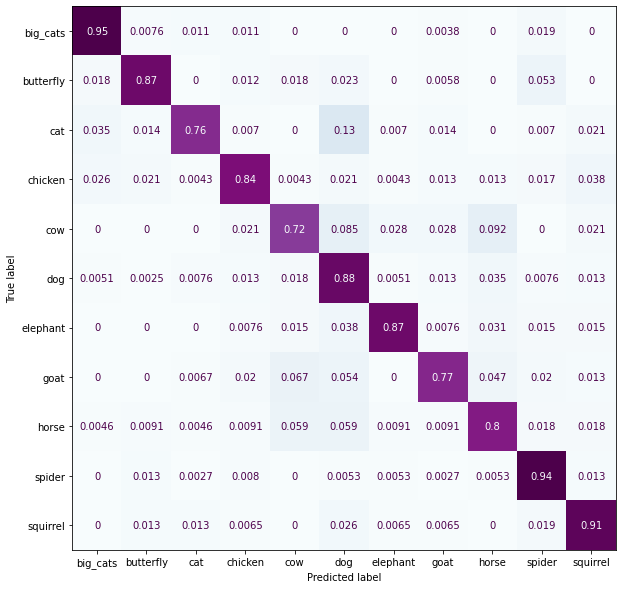

In [88]:
modified_valid_predictions = np.power(valid_predictions, 3)
for index, accuracy in enumerate(filepaths_to_load.values()):
    modified_valid_predictions[:, :, index] *= accuracy**10
modified_valid_predictions = np.sum(modified_valid_predictions, axis=2)
modified_valid_predictions = np.argmax(modified_valid_predictions, axis=1)

kaggle.print_accuracy(valid_labels, modified_valid_predictions)
kaggle.plot_confusion_matrix(valid_labels, modified_valid_predictions)

In [96]:
modified_test_predictions = np.power(test_predictions, 3)
for index, accuracy in enumerate(filepaths_to_load.values()):
    modified_test_predictions[:, :, index] *= accuracy**10
modified_test_predictions = np.sum(modified_test_predictions, axis=2)
modified_test_predictions = np.argmax(modified_test_predictions, axis=1)
kaggle.save_test_pred('models/stacking/basic_stacking_test.csv', modified_test_predictions)